#Build Naive Bayes classifiers to predict positive/negative sentiment for a coffee maker.

1. Preprocess data. Create a label column based on the product ratings. Negative sentiment is the outcome of interest. Ratings 1-3 -> negative sentiment. Ratings 4-5 -> positive sentiment. Assess label class distribution. (5 pts.)

2. Build feature representations of the reviews. Transform all words to lower case, exclude English stopwords, develop TFIDF transformed feature representation. (5 pts.)

3. Develop a Multinomial NB model to predict review sentiment. Evaluate average precision, recall, F1, ROC AUC, and PR AUC. (5 pts.)

4. Develop a Complement NB model to predict review sentiment. Evaluate average precision, recall, F1, ROC AUC, and PR AUC. (5 pts.)

<p>
Submit LastnameFirstname-A3.ipynb


1. Preprocess data. Create a label column based on the product ratings. Negative sentiment is the outcome of interest. Ratings 1-3 -> negative sentiment. Ratings 4-5 -> positive sentiment. Assess label class distribution.

In [33]:
import pandas as pd

ratings = pd.read_csv('coffee_maker.csv')

In [34]:
ratings.head()

,review_date,handle,rating,helpfulness_rating,review
0,"April 14, 2018",The Dolphin,2.0,513,Delightful coffee maker if you’re only looking...
1,"February 7, 2019",Karen Kaffenberger,1.0,122,UPDATE: Bought this 10-21-18 and I finally ret...
2,"December 23, 2017",C1C3C11,4.0,185,The big reason I ordered this was because I wa...
3,"November 26, 2016",Paul Roberts,5.0,224,I've owned several of their older brewstation ...
4,"November 28, 2017",JennyD,3.0,116,I agonized over which coffee maker to purchase...


In [35]:
ratings.shape

(5000, 5)

In [36]:
ratings.drop(['review_date', 'handle', 'helpfulness_rating'], axis=1, inplace=True)

In [37]:
ratings['sentiment'] = ratings['rating'].replace({1:1, 2:1, 3:1, 4:0, 5:0})

Negative sentiment proportion:  0.4128


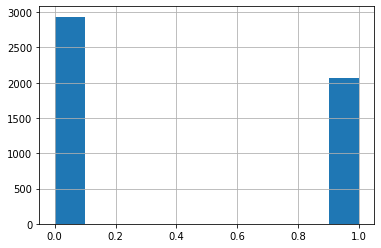

In [38]:
ratings.sentiment.hist()

print('Negative sentiment proportion: ', ratings.sentiment.mean())

**Upon re-labeling and replacing sentiment scores of either 0 or 1, it was identified that 41.28% of the data reflected Negative rating scores. The Negative rating scores (or Class 1) is the outcome class of interest because the negative sentiments will reflect where the root of information regarding product improvement and development will come from.**

2. Build feature representations of the reviews. Transform all words to lower case, exclude English stopwords, develop TFIDF transformed feature representation.

In [39]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

X = ratings['review'].values.astype(str)
y = ratings['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [40]:
nb_sent = Pipeline([
                    ('vect', CountVectorizer(lowercase=True, stop_words={'english'})),
                    ('tfidf', TfidfTransformer()),
                    ('nb', MultinomialNB()),
                    ])

nb_sent.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words={'english'}, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('nb',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

3. Develop a Multinomial NB model to predict review sentiment. Evaluate average precision, recall, F1, ROC AUC, and PR AUC.

In [41]:
from sklearn.metrics import classification_report, recall_score, precision_score, f1_score, roc_curve, auc, precision_recall_curve

pred = nb_sent.predict(X_test)
pred_prob = nb_sent.predict_proba(X_test)[:, 1]

print(classification_report(y_test, pred))

fpr, tpr, thresholds = roc_curve(y_test, pred_prob)
precision, recall, thresholds_pr = precision_recall_curve(y_test, pred)

print('ROC AUC: ', auc(fpr, tpr))
print('Precision/Recall AUC: ', auc(precision, recall))

              precision    recall  f1-score   support

         0.0       0.78      0.96      0.86       935
         1.0       0.93      0.65      0.77       715

    accuracy                           0.83      1650
   macro avg       0.86      0.81      0.82      1650
weighted avg       0.85      0.83      0.82      1650

ROC AUC:  0.9312501402340976
Precision/Recall AUC:  0.433995337995338


**Based on the chosen thresholds, the Multinomial Naive Bayes model's results are as follows:**

**This model is able to identify 65% of Negative ratings (recall of Class 1). Of the 65% of ratings that the model has flagged as Negative, 93% of them are actually Negative (precision of Class 1). The model produced a total of 715 cases that are considered Class 1.**

**The F1 scores are the harmonic averages of Positive and Negative cases. Both produced verily high scores of 86% and 77%, respectively.**

**The ROC AUC plots the distribution of True Positive cases vs. False Positive cases throughout different levels of thresholds. With a high ROC AUC score of 93%, the interpretation is that the model performs very well at distinguishing between positive and negative cases.**

**With a precision/recall AUC of 0.43, this model does suggest to have predicted value, however, the default threshold should be addressed to attain an improved level of model performance.**

4. Develop a Complement NB model to predict review sentiment. Evaluate average precision, recall, F1, ROC AUC, and PR AUC.

In [43]:
from sklearn.naive_bayes import ComplementNB

nb_sent2 = Pipeline([
                     ('vect', CountVectorizer(lowercase=True, stop_words={'english'})),
                     ('tfidf', TfidfTransformer()),
                     ('nb', ComplementNB()),
                     ])

nb_sent2.fit(X_train, y_train)

pred2 = nb_sent2.predict(X_test)
pred_prob2 = nb_sent2.predict_proba(X_test)[:, 1]

print(classification_report(y_test, pred2))

fpr2, tpr2, thresholds2 = roc_curve(y_test, pred_prob2)
precision2, recall2, thresholds_pr2 = precision_recall_curve(y_test, pred2)

print('AUC: ', auc(fpr2, tpr2))
print('Precision/Recall AUC: ', auc(precision2, recall2))

              precision    recall  f1-score   support

         0.0       0.84      0.92      0.88       935
         1.0       0.88      0.77      0.82       715

    accuracy                           0.85      1650
   macro avg       0.86      0.84      0.85      1650
weighted avg       0.86      0.85      0.85      1650

AUC:  0.9312501402340976
Precision/Recall AUC:  0.44037258919424527


**The Complement Naive Bayes model results:**

**Recall has improved for the class of interest. This model is able to identify 77% of Negative ratings, however, the Precision of those ratings actually being Negative decreased in probability to 88% precision.**

**F1 scores have actually increased in both Class 0 and 1 suggesting the improved model for the default thresholds and data for the Precision and Recall harmonic averages.**

**AUC has stayed the same as the Multinomial model AUC, which maintains the model's high level of distinguishing between positive and negative cases.**

**Precision/Recall AUC has slightly improved to 44% because of the improved calibration of probabilities that the model produces. This is a better model for the slightly imbalanced distribution of the class of interest.**